<a href="https://colab.research.google.com/github/seawavve/daconNewsTopicClassification/blob/main/KoBERT/model_holdout_valid_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경설정 

In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     |████████████████████████████████| 46.9 MB 77 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 11.7 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595754 sha256=93104de265c5ebe328c0053ddff4a0992c1e1c00125956068799fa677d552907
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 13.9 MB/s 
     |████████████████████████████████| 2.6 MB 14.8 MB/s 
     |████████████████████████████████| 636 kB 58.8 MB/s 
     |████████████████████████████████| 3.3 MB 55.8 MB/s 
     |████████████████████████████████| 895 kB 54.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully unins

In [2]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!pip install transformers==3

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-e136262n
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-e136262n
  Created wheel for kobert: filename=kobert-0.1.2-py3-none-any.whl size=12770 sha256=f11b6f71ddb689e3e7d71f33e483cc7a927029a6b4248d60390ff3e5e8195679
  Stored in directory: /tmp/pip-ephem-wheel-cache-q9lf3idx/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert
     |████████████████████████████████| 754 kB 13.8 MB/s 
     |████████████████████████████████| 3.0 MB 62.4 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.9.1
    Uninstalling transformers-4.9.1:
      Successfully uninstalled transformers-4.9.1


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [4]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [5]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

# 모델

In [6]:
##GPU 사용 시
device = torch.device("cuda:0")

In [7]:
bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [8]:
dataset_train = nlp.data.TSVDataset("aug_delete_chinese_nospecialchr.tsv", field_indices=[1,2], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset("test_data.tsv", field_indices=[1,2], num_discard_samples=1)

In [9]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [10]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [11]:
## Setting parameters
max_len = 64
batch_size = 32
warmup_ratio = 0.1
num_epochs = 3
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [12]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)
from sklearn.model_selection import train_test_split
data_train, data_valid = train_test_split(data_train, test_size=0.2, random_state=42)

In [13]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [15]:
model = BERTClassifier(bertmodel,  dr_rate=0.25).to(device)

In [16]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [17]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [18]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [19]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [20]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [21]:
import pandas as pd

import numpy as np

# ========================================
#               Training
# ========================================
train_losses=[]
train_accs=[]
val_losses=[]
val_accs=[]

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss=0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        train_loss += loss.data.cpu().numpy()
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {} loss {}".format(e+1, train_acc / (batch_id+1), train_loss / (batch_id+1) ))
    train_accs.append(train_acc / (batch_id+1))
    train_losses.append(train_loss / (batch_id+1))

    # ========================================
    #               Validation
    # ========================================


    print("")
    print("Running Validation...")

    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    val_acc=0
    val_loss=0

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        label = label.long().to(device)
        with torch.no_grad():     
            outputs = model(token_ids, valid_length, segment_ids)
        logits = outputs[0]
        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = label.to('cpu').numpy()
        val_acc += calc_accuracy(outputs, label)
        val_loss += loss.data.cpu().numpy()
    val_accs.append(val_acc / (batch_id+1))
    val_losses.append(val_loss / (batch_id+1))



# ========================================
#               Test
# ========================================
model.eval()
test_eval=[]
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    test_acc += calc_accuracy(out, label)

    
    for i in out:
        logits=i
        logits = logits.detach().cpu().numpy()
        test_eval.append(np.argmax(logits))

print("test acc {}".format(test_acc / (batch_id+1)))

# ========================================
#               Result
# ========================================
result=pd.DataFrame( test_eval, columns=['topic_idx'] )
result['index']=range(45654,45654+len(result))
result.set_index('index',inplace=True)
result.to_csv('result.csv')
#display(result)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.039902687072754 train acc 0.15625
epoch 1 batch id 201 loss 1.2498325109481812 train acc 0.3100124378109453
epoch 1 batch id 401 loss 0.5159308910369873 train acc 0.5677992518703242
epoch 1 batch id 601 loss 0.37837687134742737 train acc 0.6626455906821963
epoch 1 batch id 801 loss 0.4248753786087036 train acc 0.7100499375780275
epoch 1 batch id 1001 loss 0.46330228447914124 train acc 0.7403221778221778
epoch 1 batch id 1201 loss 0.4567362368106842 train acc 0.7594972939217319
epoch 1 batch id 1401 loss 0.28278210759162903 train acc 0.7744245182012848
epoch 1 batch id 1601 loss 0.46792179346084595 train acc 0.7870276389756402
epoch 1 batch id 1801 loss 0.43917569518089294 train acc 0.7967795669072737
epoch 1 batch id 2001 loss 0.2626383900642395 train acc 0.8049412793603199
epoch 1 batch id 2201 loss 0.3107733726501465 train acc 0.8122160381644707
epoch 1 batch id 2401 loss 0.20136772096157074 train acc 0.8183309037900874
epoch 1 batch id 2601 loss 0.277377873

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


epoch 2 batch id 1 loss 0.39318525791168213 train acc 0.84375
epoch 2 batch id 201 loss 0.13366131484508514 train acc 0.8989427860696517
epoch 2 batch id 401 loss 0.0832604169845581 train acc 0.9069513715710723
epoch 2 batch id 601 loss 0.10689420998096466 train acc 0.9130615640599001
epoch 2 batch id 801 loss 0.21481801569461823 train acc 0.9160424469413233
epoch 2 batch id 1001 loss 0.36833781003952026 train acc 0.919798951048951
epoch 2 batch id 1201 loss 0.22542612254619598 train acc 0.921940049958368
epoch 2 batch id 1401 loss 0.0982922613620758 train acc 0.9243397573162027
epoch 2 batch id 1601 loss 0.11201956123113632 train acc 0.9264522173641474
epoch 2 batch id 1801 loss 0.6201052665710449 train acc 0.92863339811216
epoch 2 batch id 2001 loss 0.12611567974090576 train acc 0.9304097951024488
epoch 2 batch id 2201 loss 0.19679389894008636 train acc 0.9325164697864607
epoch 2 batch id 2401 loss 0.10732913017272949 train acc 0.9341420241566014
epoch 2 batch id 2601 loss 0.08984375

epoch 3 batch id 1 loss 0.04208972305059433 train acc 0.96875
epoch 3 batch id 201 loss 0.020311657339334488 train acc 0.9679726368159204
epoch 3 batch id 401 loss 0.01365277636796236 train acc 0.9694513715710723
epoch 3 batch id 601 loss 0.003111323807388544 train acc 0.9727537437603994
epoch 3 batch id 801 loss 0.01577669009566307 train acc 0.9743679775280899
epoch 3 batch id 1001 loss 0.16403692960739136 train acc 0.9750561938061938
epoch 3 batch id 1201 loss 0.010204818099737167 train acc 0.9765039550374688
epoch 3 batch id 1401 loss 0.003968438133597374 train acc 0.9772706995003569
epoch 3 batch id 1601 loss 0.0059615508653223515 train acc 0.9778458775765146
epoch 3 batch id 1801 loss 0.28122973442077637 train acc 0.9784147695724598
epoch 3 batch id 2001 loss 0.18375281989574432 train acc 0.9787450024987506
epoch 3 batch id 2201 loss 0.032212208956480026 train acc 0.9793417764652431
epoch 3 batch id 2401 loss 0.013105140067636967 train acc 0.9798651603498543
epoch 3 batch id 2601 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



test acc 0.11799705975842341


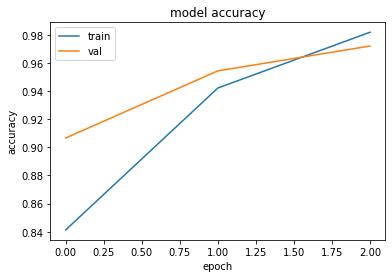

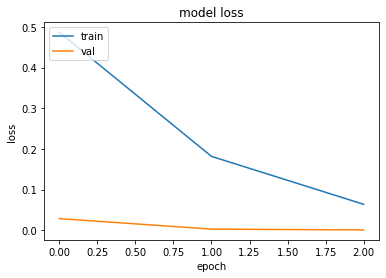

In [22]:
import matplotlib.pyplot as plt

plt.plot(train_accs)
plt.plot(val_accs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()